max point: [0.22448979591836715, -0.10204081632653073] -> 5.9549653027459435


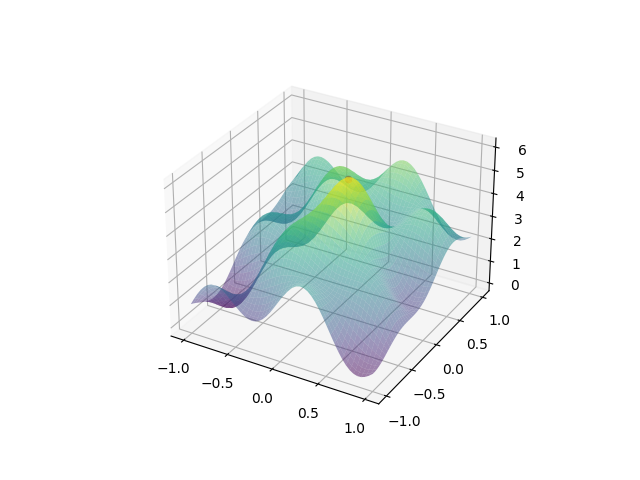

In [2]:
%matplotlib widget
"""
    We create a random 2D function to test out the parallel Bayesion optimization
    algorithm. The function is a simple sum of two sinusoidal functions. The
    algorithm should be able to find the maximum point in the function.
"""
import matplotlib.pyplot as plt
import numpy as np


# create a random 2D function to learn
def f(x):
    return (
        3
        * np.exp(
            -(((x[0] - 0.2) ** 2) / (2 * (0.1)) + ((x[1] + 0.3) ** 2) / (2 * (0.1)))
        )
        + np.cos(x[0] * 2.0)
        + np.sin(x[1] * 2.0)
        + np.cos(x[1] * 6.0) * np.sin(x[0] * 6.0)
        + 2
    )


# plot the function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
x1 = np.linspace(-1, 1, 50)
x2 = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x1, x2, indexing="ij")
Y = f([X1, X2])
ax.plot_surface(X1, X2, Y, cmap="viridis", alpha=0.5)

# get the max point, this is the ground truth
max_point = np.unravel_index(Y.argmax(), Y.shape)
max_x = [x1[max_point[0]], x2[max_point[1]]]
max_y = f(max_x)
ax.scatter(max_x[0], max_x[1], max_y, color="r", s=20)
print(f"max point: {max_x} -> {max_y}")
ground_truth = max_x

iteration 1: max point: [0.46938776 0.46938776] -> 3.5034275146953964
iteration 1: std at max point: 0.20607010415379096
iteration 2: max point: [0.14285714 0.34693878] -> 4.528894817780725
iteration 2: std at max point: 0.2788313428414142
iteration 3: max point: [ 0.10204082 -0.06122449] -> 5.165661199475037
iteration 3: std at max point: 0.21381959774554687
iteration 4: max point: [ 0.18367347 -0.10204082] -> 5.605195651410547
iteration 4: std at max point: 0.16528244727467772
iteration 5: max point: [ 0.2244898  -0.14285714] -> 5.857414062512442
iteration 5: std at max point: 0.09990571928146887
iteration 6: max point: [ 0.2244898  -0.14285714] -> 5.83830305513917
iteration 6: std at max point: 0.06821427786593891
iteration 7: max point: [ 0.2244898  -0.10204082] -> 5.857448866514476
iteration 7: std at max point: 0.06321696110745503
iteration 8: max point: [ 0.2244898  -0.10204082] -> 5.872949840274222
iteration 8: std at max point: 0.05678455102481467
iteration 9: max point: [ 0.2

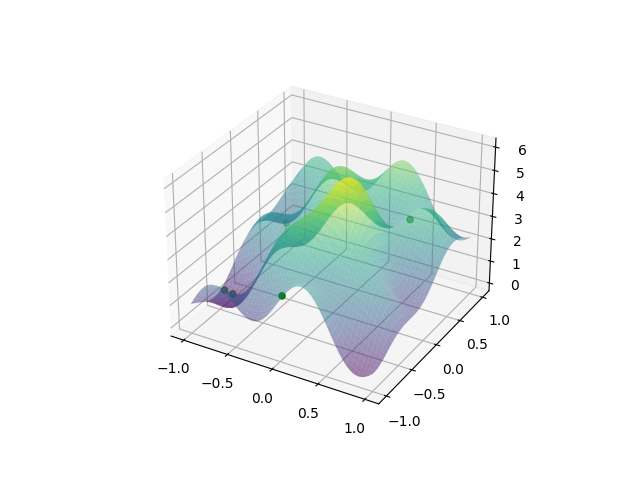

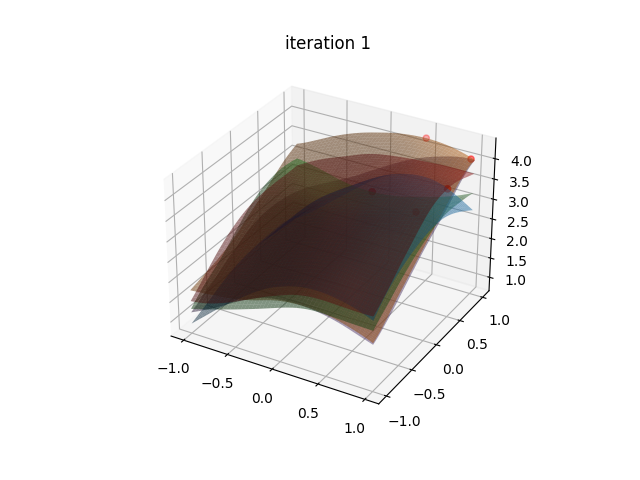

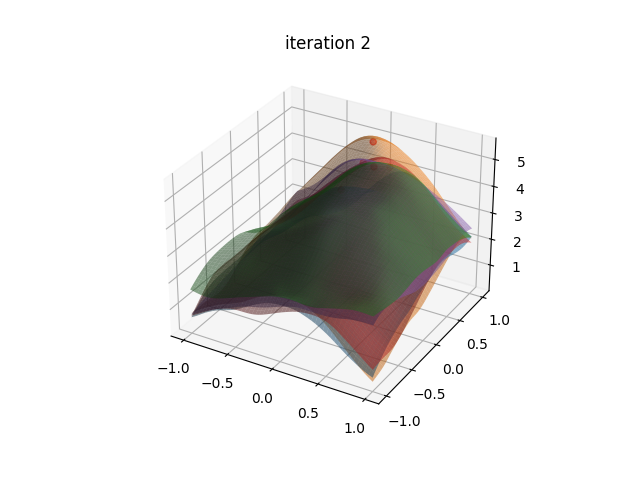

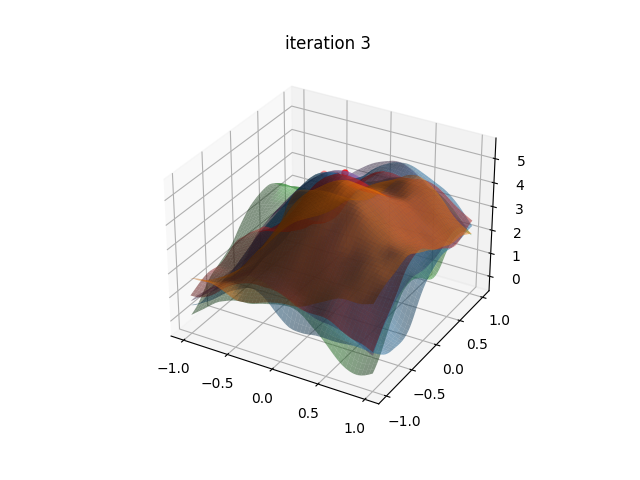

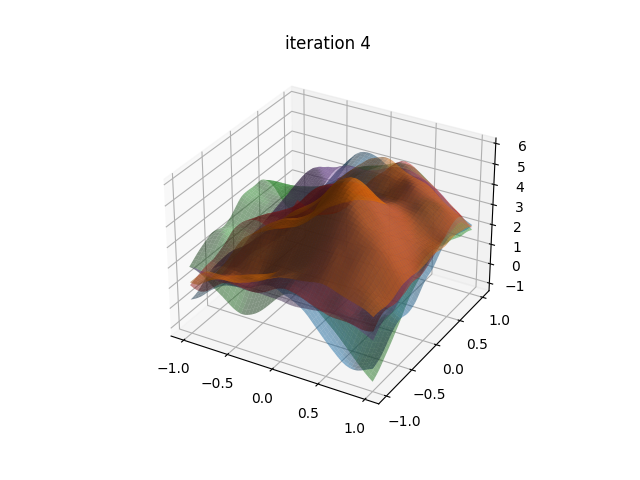

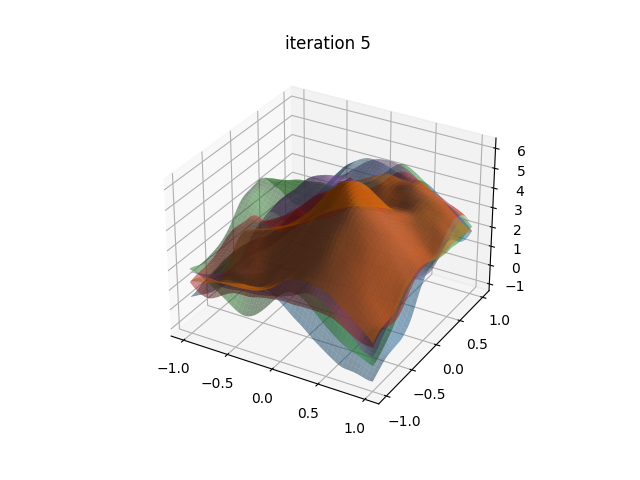

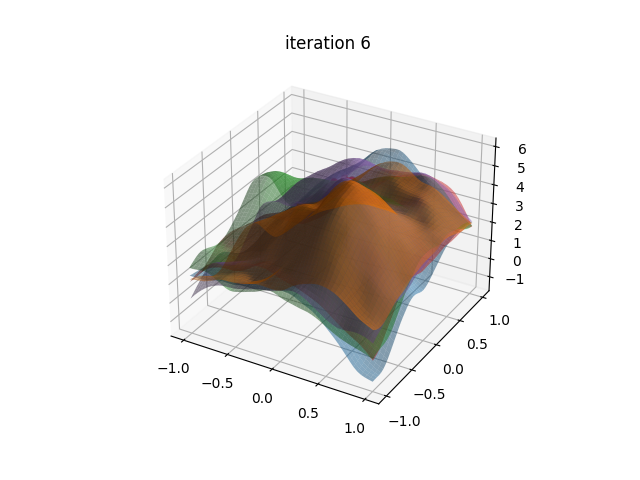

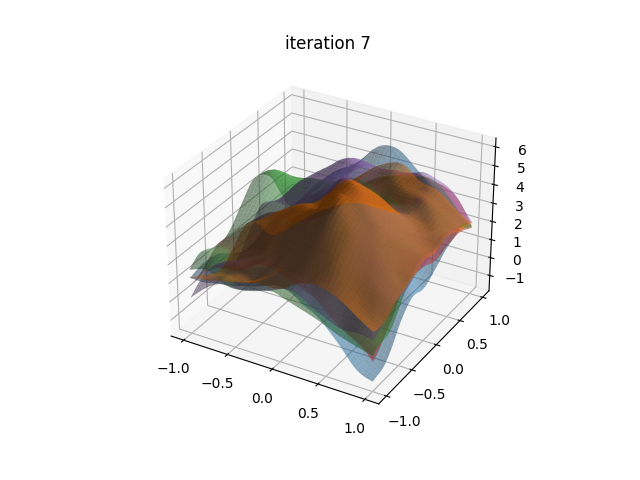

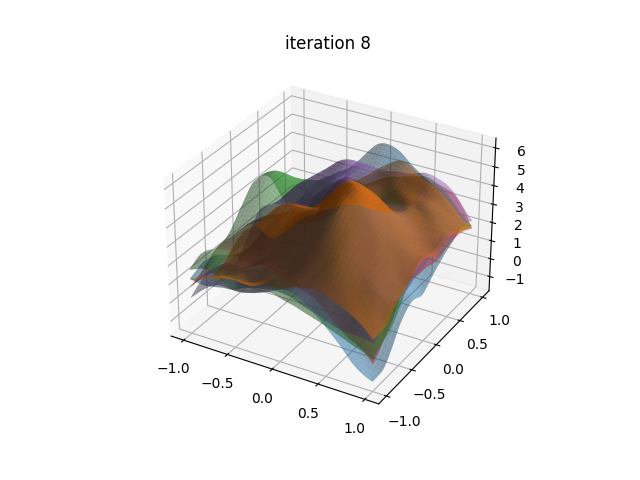

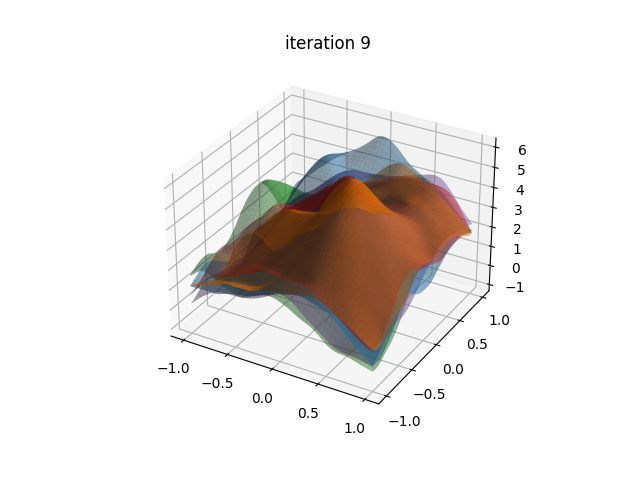

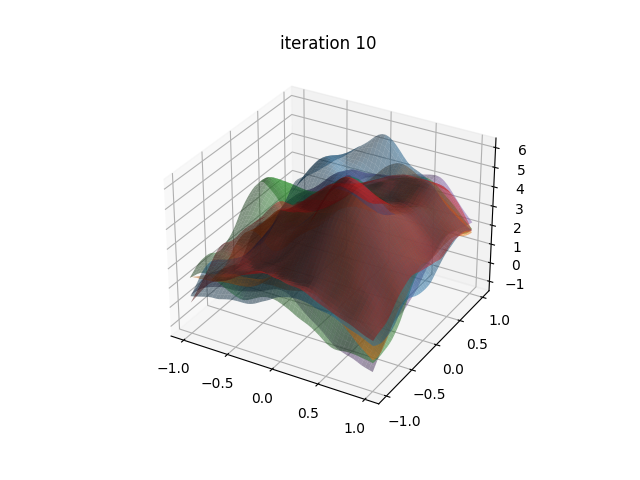

In [3]:
"""
    We run the parallel bayesian optimization algorithm to find the maximum point.

    This is based on the algorithm described in the paper:

    "Parallelised Bayesian Optimisation via Thompson Sampling"

    The algorithm is as follows:

    1. Get some random initial points from the function (sample from a uniform distribution)
    2. Fit a gaussian process to the data
    3. Sample the gaussian process then get the maximum point from the samples
    4. Evaluate the function at the locations of the maximum points from the samples
    5. Add the evaluated points to the data and repeat from step 2

    The "function" in this case would be the 2D function we created above. In practice, the
    function would be the patient response to the cortical stimulation parameters.

    We simulate noise in the function by adding gaussian noise to the function evaluations.
"""

# now create a gaussian process regessor that we want to use for bayesian optimization
from sklearn.gaussian_process import GaussianProcessRegressor

# we want to use a matern kernel
from sklearn.gaussian_process.kernels import Matern

# create the matern kernel
kernel = Matern(nu=2.5)
noise = 0.01
alpha = 0.05
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

# now get some initial data points from the function for initialization
# use a unifrom distribution to sample the points
n_points = 5
X_train = np.random.uniform(-1, 1, (n_points, 2))

# evaluate the function at the points
Y_train = np.array([f(x) for x in X_train]) + np.random.normal(
    0, noise, n_points
)

# plot the initial points on top of the ground truth
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X1, X2, Y, cmap="viridis", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train, color="g", s=20)

# store best point at each iteration
best_points = []

# do bayesian optimization loop
iterations = 10
for i in range(iterations):
    # fit the gaussian process to the data
    gpr.fit(X_train, Y_train)
    Y_pred, Y_std = gpr.predict(
        np.stack([X1.ravel(), X2.ravel()], axis=1), return_std=True
    )

    # report best point so far
    max_point = np.argmax(Y_pred)
    max_x = np.stack([X1.ravel(), X2.ravel()], axis=1)[max_point]
    max_y = Y_pred[max_point]
    print(f"iteration {i + 1}: max point: {max_x} -> {max_y}")
    # report standard deviation at max point
    max_std = Y_std[max_point]
    print(f"iteration {i + 1}: std at max point: {max_std}")
    best_points.append(max_x)

    # now sample the gpr
    samples = gpr.sample_y(np.stack([X1.ravel(), X2.ravel()], axis=1), n_samples=5)
    samples2d = samples.reshape((x1.shape[0], x2.shape[0], 5))

    # get the max point from each sample
    max_points = np.argmax(samples, axis=0)

    # get from X1 and X2 the max points
    max_x = np.stack([X1.ravel(), X2.ravel()], axis=1)[max_points]

    # plot the samples
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    for s in range(samples2d.shape[2]):
        ax.plot_surface(X1, X2, samples2d[..., s], alpha=0.5)
    # plot the max points
    ax.scatter(max_x[:, 0], max_x[:, 1], np.diag(samples[max_points, :]), c="r", s=20)
    ax.set_title("iteration %d" % (i + 1))

    # evaluate the function at the max points
    max_y = f(max_x.T) + np.random.normal(0, noise, max_x.shape[0])

    # add the max points to the training data
    X_train = np.concatenate([X_train, max_x])
    Y_train = np.concatenate([Y_train, max_y])

# report the final best point
gpr.fit(X_train, Y_train)
Y_pred, Y_std = gpr.predict(np.stack([X1.ravel(), X2.ravel()], axis=1), return_std=True)
max_point = np.argmax(Y_pred)
max_x = np.stack([X1.ravel(), X2.ravel()], axis=1)[max_point]
max_y = Y_pred[max_point]
print(f"final max point: {max_x} -> {max_y}")
max_std = Y_std[max_point]
print(f"final std at max point: {max_std}")
best_points.append(max_x)

[0.22448979591836715, -0.10204081632653073]
[[ 0.46938776  0.46938776]
 [ 0.14285714  0.34693878]
 [ 0.10204082 -0.06122449]
 [ 0.18367347 -0.10204082]
 [ 0.2244898  -0.14285714]
 [ 0.2244898  -0.14285714]
 [ 0.2244898  -0.10204082]
 [ 0.2244898  -0.10204082]
 [ 0.2244898  -0.10204082]
 [ 0.2244898  -0.10204082]
 [ 0.2244898  -0.10204082]]


Text(0.5, 1.0, 'error over iterations')

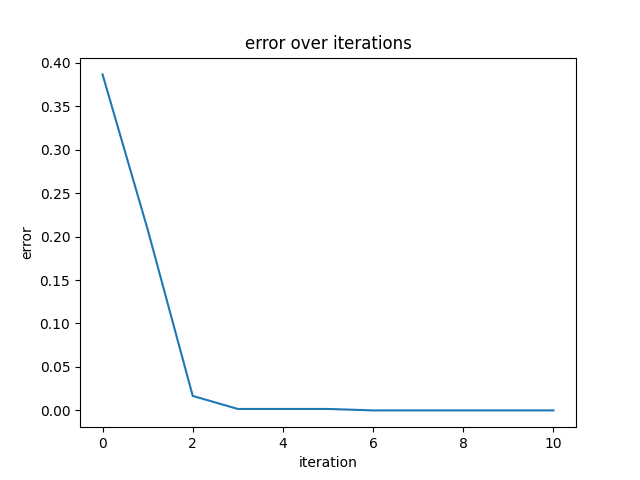

In [4]:
"""
    Plot the l2 error over the iterations
"""

# compute the squared error over the iterations
best_points = np.array(best_points)
print(ground_truth)
print(best_points)
errors = np.linalg.norm(best_points - ground_truth, axis=1) ** 2
plt.figure()
plt.plot(errors)
plt.xlabel("iteration")
plt.ylabel("error")
plt.title("error over iterations")

Text(0.5, 0.92, 'std prediction')

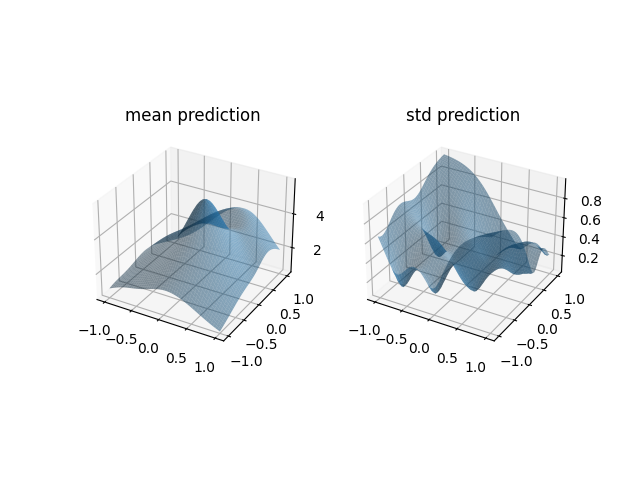

In [5]:
"""
    Plot the final gpr prediction, the mean function as well as the standard deviation function
"""

# get the gpr prediction
Y_pred, Y_std = gpr.predict(np.stack([X1.ravel(), X2.ravel()], axis=1), return_std=True)
Y_pred = Y_pred.reshape(X1.shape)
Y_std = Y_std.reshape(X1.shape)
fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X1, X2, Y_pred, alpha=0.5)
ax.set_title("mean prediction")
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(X1, X2, Y_std, alpha=0.5)
ax.set_title("std prediction")